In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [7]:
path = '../../datasets/lfw'

In [9]:
transform = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [10]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


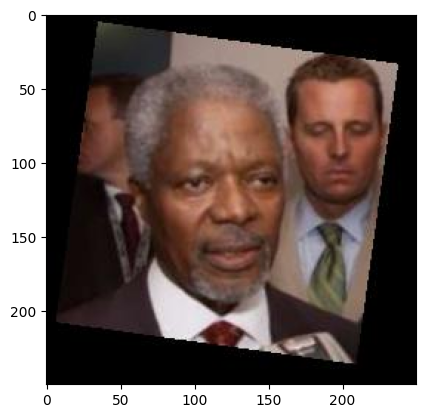

In [11]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [12]:
for x, y in dataloader:
    # As the previous block of code in Step 1, we will take the first data
    sample_data = x[0]

    # Then, print the dimensions of the image
    print("Data dimensions:", sample_data.shape)
    break

Data dimensions: torch.Size([3, 250, 250])


- The first dimension `3` indicates us the number of channel. So in this case, `3` means that the image has a RGB (Red - Green - Blue) format.  
- The second dimension `250` represents the height of the image
- And the third, `250` again reprensents the width of the image

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [83]:
class AE(nn.Module):
    
    def __init__(self):
        super(AE,self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),  # 64, 125, 125
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # 64, 63, 63
            nn.Conv2d(64, 128, 3, stride=2),  # 128, 32, 32
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2),  # 64, 63, 63
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, stride=2),  # 3, 126, 126
            nn.ReLU(True),
            nn.ConvTranspose2d(3, 3, 4, stride=2),  # 3, 25, 252
            nn.Sigmoid()
        )

    def encoder(self, x):
        return self.encoder(x)

    def decoder(self, x):
        return self.decoder(x)
       
    def forward(self, x):
        h   = self.encoder(x)
        out = self.decoder(h)
        return out
       

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [84]:
#Create instance of the class
model = AE()

# Pass the input image through the model
output_image = model(sample_data) #We took the sample data from the step 2

# Print the shapes of encoder and decoder outputs
encoderOutput = model.encoder(output_image)
decoderOutput = model.decoder(encoderOutput)
print("Encoder output shape:", encoderOutput.shape)
print("Decoder output shape:", decoderOutput.shape)

Encoder output shape: torch.Size([128, 30, 30])
Decoder output shape: torch.Size([3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [86]:
# Print the total number of parameters in the model
# AI help me to know how to do it
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters in the model:", total_params)

Total number of parameters in the model: 152662


In [88]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [89]:
loss_function = nn.MSELoss()

In the case of autoencoder for image reconstruction, the **Mean Squared Error** loss function is commonly used and appropriate among those I know by measuring the average squared difference between the predicted values and the actual data. 

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [96]:
num_epochs = 5
for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, y = data
        
        # ===================forward=====================
        output = model(img)
        loss = loss_function(output, img)
        
        # ===================backward====================
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.data
        
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))

epoch [1/5], loss:1.2368
epoch [2/5], loss:1.1114
epoch [3/5], loss:0.9992
epoch [4/5], loss:0.8731
epoch [5/5], loss:0.8017


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

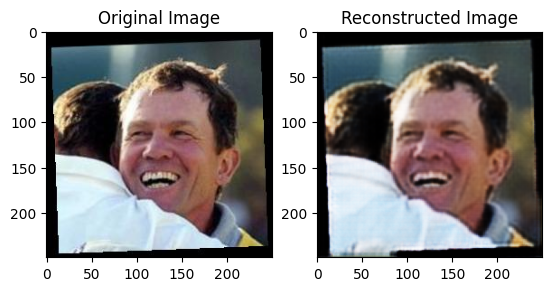

In [109]:
# Take a random image from the dataset
for x, y in dataloader:
    original_img = x[2]
    break

# Pass the original image through the autoencoder
with torch.no_grad():
    reconstructed_img = model(original_img)  # Add batch dimension

# Convert tensors to numpy arrays for visualization
original_img_np = original_img.permute(1, 2, 0).numpy() 
reconstructed_img_np = reconstructed_img.squeeze().permute(1, 2, 0).numpy()

# Plot the images
plt.subplot(1, 2, 1)
plt.imshow(original_img_np)
plt.title("Original Image")

plt.subplot(1, 2, 2) #In order to have the plot next to each other
plt.imshow(reconstructed_img_np)
plt.title("Reconstructed Image")

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

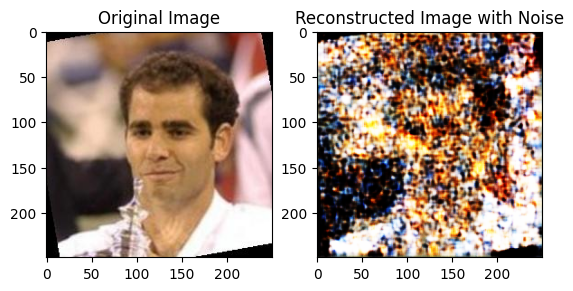

In [128]:
# Take a random image from the dataset
for x, y in dataloader:
    original_img = x[2]
    break

# Pass the original image through the autoencoder
with torch.no_grad():
    encoder_img = model.encoder(original_img)

    # Add small normally distributed noise
    noise = torch.randn_like(encoder_img) * 2
    noisy_encoder_img = encoder_img + noise
    noisy_reconstructed_img = model.decoder(noisy_encoder_img)


# Convert tensors to numpy arrays for visualization
original_img_np = original_img.permute(1, 2, 0).numpy() 
noisy_reconstructed_img_np = noisy_reconstructed_img.squeeze().permute(1, 2, 0).numpy()

# Plot the images
plt.subplot(1, 2, 1)
plt.imshow(original_img_np)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(noisy_reconstructed_img_np)
plt.title("Reconstructed Image with Noise")

plt.show()

Adding noise to the latent representation of the input image is affecting the decoded image and prevent him to reconstruct the original image because the decoder is working with a perturbed and potentially less informative latent code. We can see that by noticing blurriness and distortion in the reconstructed image.